In [3]:
%%capture
!pip install rdkit torch_geometric sklearn.preprocessing

In [1]:
import numpy as np
import pandas as pd
import copy
import math
import csv

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from rdkit import Chem
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.nn import MLP
from torch_geometric.utils.smiles import from_smiles

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("final_result2.0_zero_filled.csv")

In [3]:
torch.manual_seed(12345)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(12345)

In [4]:
# ----------------
# Task groups
# ----------------

TARGET_COLS_PHYS_CHEM = ["Solubility", "Molecular_Weight", "Log_P", "BoilingPoint"]     # 4
TARGET_COLS_OPT_QUANT = ["sigma_780nm", "max_sigma", "ISC(S1-T1)"]                      # 3
TARGET_COLS_STRUC_TOX = ["SAscore", "Tox_score"]                                        # 2
TARGET_COL_OTHER      = ["is_aromatic"]                                                 # 1

REG_COLS = TARGET_COLS_PHYS_CHEM + TARGET_COLS_OPT_QUANT + TARGET_COLS_STRUC_TOX        # 9 regression cols
BIN_COL  = TARGET_COL_OTHER[0]                                                          # 1 binary col

In [5]:
# -----------------------------------------------------------------
# Preprocess SMILES strings to generate graphs using RDKit and PyG
# -----------------------------------------------------------------

def smiles_to_graph(smiles: str):
    try:
        # Returns Data(x, edge_index, edge_attr)
        # edge_attr is bond features (you can ignore for now unless you upgrade the model)
        data = from_smiles(smiles, with_hydrogen=True, kekulize=False)
        return data
    except Exception:
        print("wrong SMILES")
        return None

In [6]:
# -----------------------
# PyG Dataset wrapper
# -----------------------

class GraphListDataset(Dataset):
    def __init__(self, data_list):
        super().__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

In [7]:
# -------------------------
# create graphs dataset 
# -------------------------

data_list = []
for _, row in df.iterrows():
    g = smiles_to_graph(row["SMILES"])
    if g is None:
        continue

    g.x = g.x.float()

    y_reg_raw  = row[REG_COLS].to_numpy(dtype=np.float32)              # (9,)
    y_arom_raw = np.array([row[BIN_COL]], dtype=np.float32)            # (1,) should be 0/1

    g.y_reg_raw  = torch.tensor(y_reg_raw, dtype=torch.float32)        # (9,)
    g.y_arom_raw = torch.tensor(y_arom_raw, dtype=torch.float32)       # (1,)

    data_list.append(g)

dataset = GraphListDataset(data_list)
print(f"Total graphs: {len(dataset)}")

Total graphs: 211137


In [8]:
# inspect one graph's tensor shapes
g0 = dataset[21651]
print("graph[0].x shape:", tuple(g0.x.shape))                      # (num_nodes, num_node_features)
print("graph[0].edge_index shape:", tuple(g0.edge_index.shape))    # (2, num_edges*2) if bidirectional
print("graph[0].edge_attr shape:", tuple(g0.edge_attr.shape))
print("graph[0].y_raw shape:", tuple(g0.y_reg_raw.shape))          # (len(TARGET_COLS),)
print("graph[0].y_raw shape:", tuple(g0.y_arom_raw.shape))

graph[0].x shape: (19, 9)
graph[0].edge_index shape: (2, 44)
graph[0].edge_attr shape: (44, 3)
graph[0].y_raw shape: (9,)
graph[0].y_raw shape: (1,)


In [9]:
# -----------------------------------------------------------
# Split dataset into training and test datasets (95/5 split)
# -----------------------------------------------------------

torch.manual_seed(12345)
dataset = dataset.shuffle()
train_cut = int(0.95 * len(dataset))
test_size = len(dataset) - train_cut
train_dataset = dataset[:train_cut]
test_dataset = dataset[train_cut:]

In [10]:
# sanity check
print(f"Number of training graphs: {len(train_dataset)}")
print(f"Number of validation graphs: {len(test_dataset)}")

Number of training graphs: 200580
Number of validation graphs: 10557


In [11]:
# --------------------------------
# Masking, Normalizing & Batching
# --------------------------------

# Create per-graph ZERO mask on the RAW regression targets (REG_COLS)
# Attach as d.y_mask
for d in train_dataset:
    d.y_mask_raw = (d.y_reg_raw != 0).float()   # (9,) 1==valid, 0==zero
for d in test_dataset:
    d.y_mask_raw = (d.y_reg_raw != 0).float()   # (9,) 1==valid, 0==zero

# Fit scaler on TRAIN regression targets
scaler = StandardScaler()
train_reg = torch.stack([d.y_reg_raw for d in train_dataset], dim=0).cpu().numpy()  # (N_train, 9)
scaler.fit(train_reg)

# Attach normalized regression targets + raw binary targets + mask
for d in train_dataset:
    reg_norm = scaler.transform(d.y_reg_raw.view(1, -1).cpu().numpy()).astype(np.float32)[0]  # (9,)
    d.y_reg  = torch.tensor(reg_norm, dtype=torch.float32).view(1, -1)                        # (1, 9)
    d.y_mask = d.y_mask_raw.view(1, -1)                                                       # (1, 9)
    d.y_arom = d.y_arom_raw.view(1, -1).float()                                               # (1, 1) 0/1

for d in test_dataset:
    reg_norm = scaler.transform(d.y_reg_raw.view(1, -1).cpu().numpy()).astype(np.float32)[0]
    d.y_reg  = torch.tensor(reg_norm, dtype=torch.float32).view(1, -1)
    d.y_mask = d.y_mask_raw.view(1, -1)
    d.y_arom = d.y_arom_raw.view(1, -1).float()

# Build loaders AFTER targets are attached
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [12]:
# sanity check 1
print("train_reg shape:", train_reg.shape)              # should be (N_train, 9)
print("scaler.mean_.shape:", scaler.mean_.shape)        # (9,)
print("scaler.scale_.shape:", scaler.scale_.shape)      # (9,)
print("first 9 means:", scaler.mean_[:10])
print("first 9 stds:", scaler.scale_[:10])

train_reg shape: (200580, 9)
scaler.mean_.shape: (9,)
scaler.scale_.shape: (9,)
first 9 means: [6.68712438e+04 1.61447319e+02 9.86596597e-01 2.48093641e+02
 1.21627415e+02 1.51308171e+02 1.07200107e-01 1.22256239e-01
 5.95072797e-01]
first 9 stds: [1.58453296e+05 6.90902231e+01 1.49690708e+00 1.41872937e+02
 1.00084062e+02 1.15488243e+02 8.75399192e-02 1.20896360e-01
 9.47371486e-02]


In [13]:
# sanity check 2 
train_y_norm = scaler.transform(train_reg)
print("col means (train, after):", train_y_norm.mean(axis=0))       # when transform again, mean close to 0, and stds close to 1
print("col stds  (train, after):", train_y_norm.std(axis=0))        # which is normal distribution 

col means (train, after): [-4.2087839e-07 -1.2795178e-08 -2.8530174e-08 -4.3606096e-07
 -1.0712035e-07 -1.8985979e-07  1.9244770e-07  7.3182322e-09
 -5.9837544e-09]
col stds  (train, after): [0.99959755 1.0002462  0.99999523 0.9999992  0.9998855  1.0001272
 1.0000625  0.9999858  0.9999738 ]


In [14]:
# -------------
# Define Model
# -------------

class MultiTaskGAT(nn.Module):
    def __init__(self, hidden_channels=128):
        super().__init__()
        torch.manual_seed(12345)

        # GCN layers
        # GINConv layers, each with an MLP
        self.conv1 = GATConv(9, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)

        # Fully connected layers for different tasks (heads)

        # For phys_chem head: 128 -> 64 -> 4
        self.fc_phys_chem_1 = nn.Linear(128, 128)
        self.fc_phys_chem_2 = nn.Linear(128, 64)
        self.fc_phys_chem_3 = nn.Linear(64, 4)

        # For opt_quant head: 128 -> 64 -> 3
        self.fc_opt_quant_1 = nn.Linear(128, 128)
        self.fc_opt_quant_2 = nn.Linear(128, 64)
        self.fc_opt_quant_3 = nn.Linear(64, 3)

        # For struc_tox head: 128 -> 64 -> 2
        self.fc_struc_tox_1 = nn.Linear(128, 64)
        self.fc_struc_tox_2 = nn.Linear(64, 2)

        # For other head: 128 -> 64 -> 32 -> 1 (logits)
        self.fc_other_1 = nn.Linear(128, 64)
        self.fc_other_2 = nn.Linear(64, 32)
        self.fc_other_3 = nn.Linear(32, 1)  # logits for BCEWithLogitsLoss

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index)

        # Apply global mean pooling
        x = global_mean_pool(x, batch)

        # Apply dropout for regularization
        x = F.dropout(x, p=0.2, training=self.training)

        # Phys_chem # (B,4)
        phys = self.fc_phys_chem_1(x).relu()
        phys = self.fc_phys_chem_2(phys).relu()
        phys = self.fc_phys_chem_3(phys)

        # Opt_quant # (B,3)
        opt = self.fc_opt_quant_1(x).relu()
        opt = self.fc_opt_quant_2(opt).relu()
        opt = self.fc_opt_quant_3(opt)
        

        # Struc_tox # (B,2)
        tox = self.fc_struc_tox_1(x).relu()
        tox = self.fc_struc_tox_2(tox)

        # Other # (B,1) logits
        arom = self.fc_other_1(x).relu()
        arom = self.fc_other_2(arom).relu()
        arom = self.fc_other_3(arom)  # logits for BCEWithLogitsLoss

        return phys, opt, tox, arom
    

In [15]:
# ---------------------------
# Training Tools & Parameter 
# ---------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskGAT(hidden_channels=128).to(device)

# Use AdamW optimizer instead of Adam
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-4)

# Learning rate scheduler: Reduce learning rate on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.1, patience=5, threshold=1e-4, threshold_mode='rel'
)

# ---------------------------------------------------------
# UPDATED masked MSE with new semantics:
# mask==1 means "use this entry"
# mask==0 means "ignore this entry"
# ---------------------------------------------------------

def masked_mse(pred: torch.Tensor, target: torch.Tensor, valid_mask: torch.Tensor) -> torch.Tensor:
    """
    pred/target: (B, k)
    valid_mask:  (B, k) with 1==valid/use, 0==ignore
    """
    valid = valid_mask.to(dtype=pred.dtype)
    se = (pred - target).pow(2) * valid
    denom = valid.sum().clamp_min(1.0)
    return se.sum() / denom

criterion_bce = nn.BCEWithLogitsLoss()  

print(model)

MultiTaskGAT(
  (conv1): GATConv(9, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (fc_phys_chem_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_phys_chem_2): Linear(in_features=128, out_features=64, bias=True)
  (fc_phys_chem_3): Linear(in_features=64, out_features=4, bias=True)
  (fc_opt_quant_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_opt_quant_2): Linear(in_features=128, out_features=64, bias=True)
  (fc_opt_quant_3): Linear(in_features=64, out_features=3, bias=True)
  (fc_struc_tox_1): Linear(in_features=128, out_features=64, bias=True)
  (fc_struc_tox_2): Linear(in_features=64, out_features=2, bias=True)
  (fc_other_1): Linear(in_features=128, out_features=64, bias=True)
  (fc_other_2): Linear(in_features=64, out_features=32, bias=True)
  (fc_other_3): Linear(in_features=32, out_features=1, bias=True)
)


In [16]:
# ------------------------
# Define Training process
# ------------------------

def train_epoch():
    model.train()
    total = 0.0
    n = 0

    for data in train_loader:
        data = data.to(device)
        phys_out, opt_out, tox_out, arom_logit = model(data.x.float(), data.edge_index, data.batch)

        y_reg  = data.y_reg          # (B, 7)
        y_mask = data.y_mask         # (B, 7)
        y_arom = data.y_arom         # (B, 1)

        y_phys = y_reg[:, 0:4]
        y_opt  = y_reg[:, 4:7]
        y_tox  = y_reg[:, 7:9]

        m_phys = y_mask[:, 0:4]
        m_opt  = y_mask[:, 4:7]
        m_tox  = y_mask[:, 7:9]

        loss_phys = masked_mse(phys_out, y_phys, m_phys) 
        loss_opt  = masked_mse(opt_out,  y_opt,  m_opt)
        loss_tox  = masked_mse(tox_out,  y_tox,  m_tox)
        loss_arom = criterion_bce(arom_logit, y_arom)

        optimizer.zero_grad(set_to_none=True)
        loss_phys.backward(retain_graph=True)
        loss_opt.backward(retain_graph=True)
        loss_tox.backward(retain_graph=True)
        loss_arom.backward()
        
        optimizer.step()

        total += (loss_phys + loss_opt + loss_tox + loss_arom).item()
        n += 1

    return total / max(n, 1)


@torch.no_grad()
def eval_loss(loader):
    model.eval()
    total = 0.0
    n = 0

    for data in loader:
        data = data.to(device)
        phys_out, opt_out, tox_out, arom_logit = model(data.x.float(), data.edge_index, data.batch)

        y_reg  = data.y_reg
        y_mask = data.y_mask
        y_arom = data.y_arom

        y_phys = y_reg[:, 0:4]
        y_opt  = y_reg[:, 4:7]
        y_tox  = y_reg[:, 7:9]

        m_phys = y_mask[:, 0:4]
        m_opt  = y_mask[:, 4:7]
        m_tox  = y_mask[:, 7:9]

        loss_phys = masked_mse(phys_out, y_phys, m_phys)
        loss_opt  = masked_mse(opt_out,  y_opt,  m_opt) 
        loss_tox  = masked_mse(tox_out,  y_tox,  m_tox) 
        loss_arom = criterion_bce(arom_logit, y_arom) 

        total += (loss_phys + loss_opt + loss_tox + loss_arom).item()
        n += 1

    return total / max(n, 1)

In [17]:
# ----------------------------
# Train + log to CSV
# ----------------------------
num_epochs = 500
log_path = "loss_log.csv"

best_test = math.inf
best_epoch = -1
best_train_loss = None
best_test_loss = None
best_model_state = None
best_optimizer_state = None
best_scheduler_state = None

with open(log_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "test_loss"])  # header

    for epoch in range(1, num_epochs + 1):
        
        train_loss = train_epoch()
        test_loss  = eval_loss(test_loader)
        scheduler.step(test_loss)

        writer.writerow([epoch, float(train_loss), float(test_loss)])
        print(f"Epoch: {epoch:03d}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")

        # find best model 
        if test_loss < best_test:
            best_test = float(test_loss)
            best_epoch = epoch
            
            best_train_loss = float(train_loss)
            best_test_loss  = float(test_loss)

            best_model_state = copy.deepcopy(model.state_dict())
            best_optimizer_state = copy.deepcopy(optimizer.state_dict())
            best_scheduler_state = copy.deepcopy(scheduler.state_dict())

print(f"Saved: {log_path}")

Epoch: 001, Train Loss: 1.564228, Test Loss: 1.018621
Epoch: 002, Train Loss: 1.121832, Test Loss: 1.295455
Epoch: 003, Train Loss: 0.983789, Test Loss: 0.704964
Epoch: 004, Train Loss: 0.892579, Test Loss: 0.648839
Epoch: 005, Train Loss: 0.838887, Test Loss: 0.640310
Epoch: 006, Train Loss: 0.808329, Test Loss: 0.605932
Epoch: 007, Train Loss: 0.817008, Test Loss: 0.592390
Epoch: 008, Train Loss: 0.770989, Test Loss: 0.560485
Epoch: 009, Train Loss: 0.770982, Test Loss: 0.557011
Epoch: 010, Train Loss: 0.758354, Test Loss: 0.529379
Epoch: 011, Train Loss: 0.760145, Test Loss: 0.615074
Epoch: 012, Train Loss: 0.710628, Test Loss: 0.491008
Epoch: 013, Train Loss: 0.738585, Test Loss: 0.483107
Epoch: 014, Train Loss: 0.706956, Test Loss: 0.500347
Epoch: 015, Train Loss: 0.677321, Test Loss: 0.488505
Epoch: 016, Train Loss: 0.727495, Test Loss: 0.470166
Epoch: 017, Train Loss: 0.686292, Test Loss: 0.483164
Epoch: 018, Train Loss: 0.682479, Test Loss: 0.619107
Epoch: 019, Train Loss: 0.66

In [18]:
# ----------------------------
# Save 
# ----------------------------

# LAST model
torch.save({
    "epoch": epoch,
    "train_loss": float(train_loss),
    "test_loss": float(test_loss),
    
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    
    "scaler_mean": scaler.mean_,
    "scaler_scale": scaler.scale_,
    "reg_cols": REG_COLS,
    "bin_col": BIN_COL,  
    }, 
    "multitask_GAT_last.pth"
)


# BEST model
torch.save({
    "epoch": best_epoch,
    "train_loss": best_train_loss,
    "test_loss": best_test_loss,
    
    "model_state_dict": best_model_state,
    "optimizer_state_dict": best_optimizer_state,
    "scheduler_state_dict": best_scheduler_state,
    
    "scaler_mean": scaler.mean_,
    "scaler_scale": scaler.scale_,
    "reg_cols": REG_COLS,
    "bin_col": BIN_COL,
    }, 
    "multitask_GAT_best.pth"
)

In [19]:
# ----------------------------
# Load Model
# ----------------------------

# Load the best model checkpoint
checkpoint = torch.load('multitask_GAT_best.pth',weights_only=False)
scaler_mean = np.array(checkpoint["scaler_mean"], dtype=np.float32)         # (9,)
scaler_scale = np.array(checkpoint["scaler_scale"], dtype=np.float32)       # (9,)

# Recreate the model architecture
model = MultiTaskGAT(hidden_channels=128).to(device)

# Load the model state_dict
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()                                                                # Set model to evaluation mode

MultiTaskGAT(
  (conv1): GATConv(9, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (fc_phys_chem_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_phys_chem_2): Linear(in_features=128, out_features=64, bias=True)
  (fc_phys_chem_3): Linear(in_features=64, out_features=4, bias=True)
  (fc_opt_quant_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_opt_quant_2): Linear(in_features=128, out_features=64, bias=True)
  (fc_opt_quant_3): Linear(in_features=64, out_features=3, bias=True)
  (fc_struc_tox_1): Linear(in_features=128, out_features=64, bias=True)
  (fc_struc_tox_2): Linear(in_features=64, out_features=2, bias=True)
  (fc_other_1): Linear(in_features=128, out_features=64, bias=True)
  (fc_other_2): Linear(in_features=64, out_features=32, bias=True)
  (fc_other_3): Linear(in_features=32, out_features=1, bias=True)
)

In [20]:
test_df = pd.read_csv("3000testbank.csv")
data_list = []

for _, row in test_df.iterrows():
    graph = smiles_to_graph(row["SMILES"])
    if graph is not None:
        data_list.append(graph)

test_dataset = GraphListDataset(data_list)

In [21]:
# ----------------------------
# Make Prediction
# ----------------------------

# Function to compute RMSE
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Function to compute Pearson correlation
def pearson_r(x, y):
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0, 1]

# Initialize list for predictions
predictions = []

# Inverse transform function to denormalize the predictions
def reg_inverse_transform(z_norm_1x9: np.ndarray) -> np.ndarray:
    # z_norm = (x - mean)/scale  => x = z_norm*scale + mean
    return z_norm_1x9 * scaler_scale + scaler_mean

# Iterate through the test dataset and make predictions
for data in test_dataset:
    data = data.to(device)
    
    # Run the model to get predictions
    phys_out, opt_out, tox_out, arom_logit = model(data.x.float(), data.edge_index, data.batch)
    
    # Concatenate predictions from each task (normalized)
    pred_reg_norm = torch.cat([phys_out, opt_out, tox_out], dim=1).detach().cpu().numpy()  # (1, 9)
    pred_arom = arom_logit.detach().cpu().numpy().reshape(1, -1)
    
    # Apply inverse transformation to get predictions in raw scale
    pred_reg_raw = reg_inverse_transform(pred_reg_norm)  # (1, 9)
    
    # Store predictions
    predictions.append(np.concatenate([pred_reg_raw, pred_arom], axis=1))
    # predictions.append(pred_reg_raw)

# Convert predictions to a numpy array for easier processing later
predictions = np.array(predictions)

# Squeeze the second dimension (which has size 1)
predictions = np.squeeze(predictions, axis=1)  # Shape: (3000, 10)

In [22]:
print(predictions.shape)

(3000, 10)


In [23]:
# Load true values from CSV
true_values = test_df[["Solubility", "Molecular_Weight", "Log_P", "BoilingPoint", "sigma_780nm",
                       "max_sigma", "ISC(S1-T1)", "SAscore", "Tox_score", "is_aromatic"]].to_numpy()

In [24]:
# ----------------------------
# Recording R2 & RMSE
# ----------------------------

# Initialize a list to store the results
results = []

# Compute RMSE and Pearson correlation for each property
for i, prop in enumerate(REG_COLS + [BIN_COL]):  # Includes both regression and arom_logit
    y_true = true_values[:, i]
    y_pred = predictions[:, i]

    # Filter out NaN values (only valid pairs will be considered)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    if len(y_true) == 0:
        print(f"{prop}: no valid pairs (all NA)")
        continue

    # Compute RMSE
    property_rmse = rmse(y_true, y_pred)

    # Compute Pearson correlation
    property_pearson = pearson_r(y_true, y_pred)

    # Print the results for all properties, including "is_aromatic"
    print(f"{prop} RMSE: {property_rmse:.4f} , Pearson r: {property_pearson:.4f}")

    # Append the results for this property
    results.append([prop, property_pearson, property_rmse])

# Define the header for the CSV
header = ["Property", "Pearson r", "RMSE"]

# Write the results to a CSV file
output_csv = "R2&RMSE_PNA.csv"
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)  # Write the header
    writer.writerows(results)  # Write the data rows

print(f"Results saved to {output_csv}")

Solubility RMSE: 146626.8803 , Pearson r: 0.3514
Molecular_Weight RMSE: 111.4434 , Pearson r: 0.6646
Log_P RMSE: 1.5156 , Pearson r: 0.6853
BoilingPoint RMSE: 268.9327 , Pearson r: 0.5463
sigma_780nm RMSE: 125.5000 , Pearson r: 0.3460
max_sigma RMSE: 150.4180 , Pearson r: 0.3212
ISC(S1-T1) RMSE: 0.0505 , Pearson r: 0.4488
SAscore RMSE: 0.1137 , Pearson r: 0.6073
Tox_score RMSE: 0.1139 , Pearson r: 0.8961
is_aromatic RMSE: 28.2846 , Pearson r: 0.8420
Results saved to R2&RMSE_PNA.csv


Solubility: Pearson r = 0.351
Molecular_Weight: Pearson r = 0.665
Log_P: Pearson r = 0.685
BoilingPoint: Pearson r = 0.546
sigma_780nm: Pearson r = 0.346
max_sigma: Pearson r = 0.321
ISC(S1-T1): Pearson r = 0.449
SAscore: Pearson r = 0.607
Tox_score: Pearson r = 0.896
is_aromatic: Pearson r = 0.842


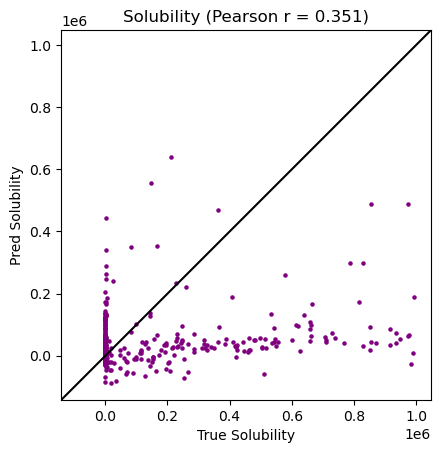

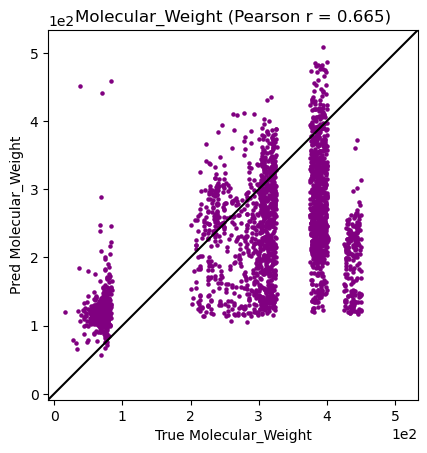

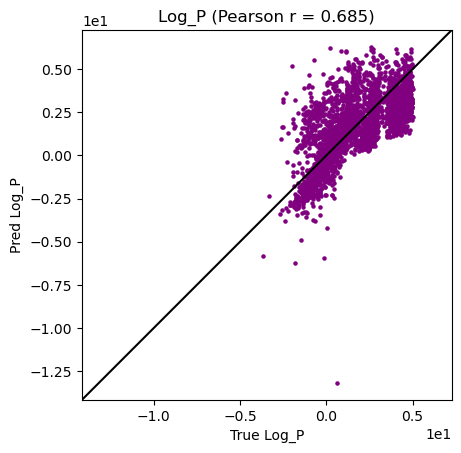

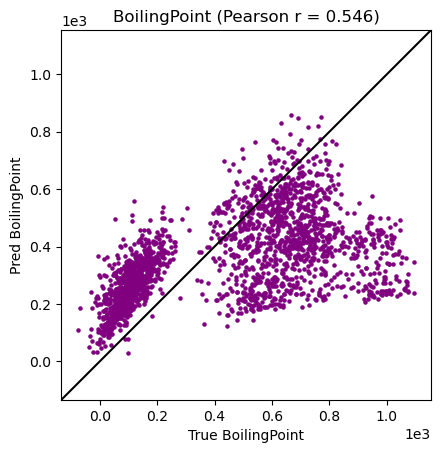

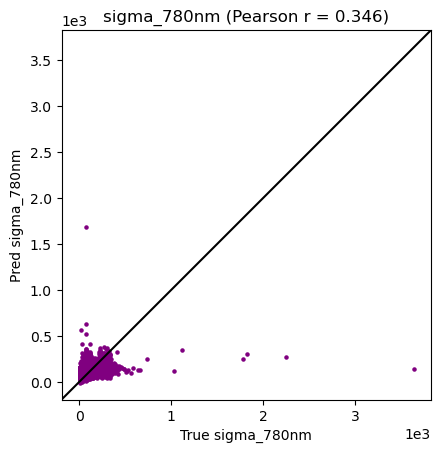

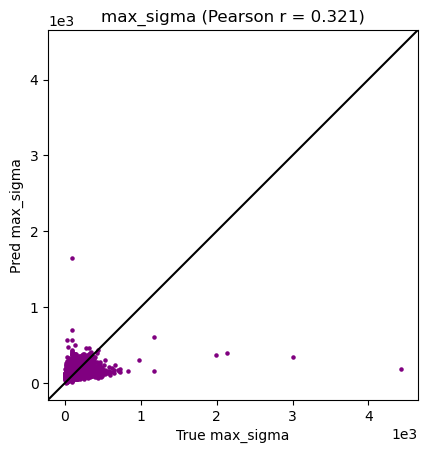

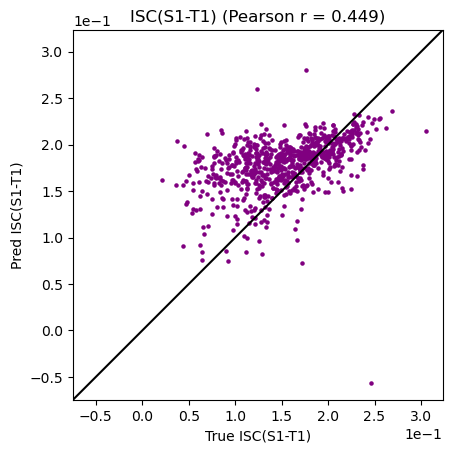

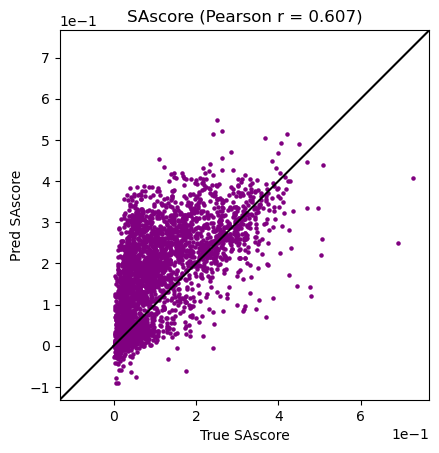

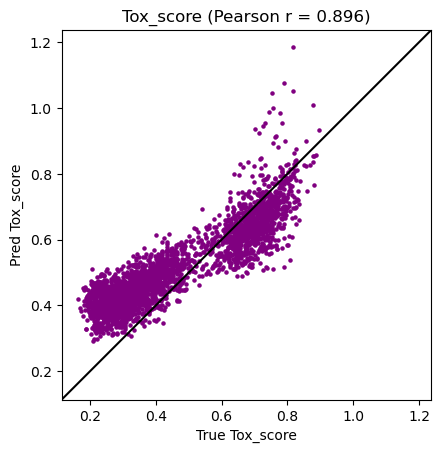

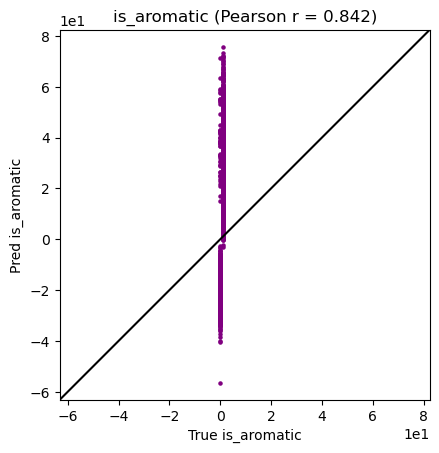

In [25]:
# ----------------------------
# Drawing R2
# ----------------------------

# Dictionary to store Pearson correlation for each property
r_by_prop = {}

# Iterate through each property
for i, prop in enumerate(REG_COLS + [BIN_COL]):  # Includes both regression and arom_logit
    y_true = true_values[:, i]
    y_pred = predictions[:, i]

    # Filter out NaN values (only valid pairs will be considered)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Skip properties with no valid data points
    if len(y_true) == 0:
        r_by_prop[prop] = np.nan
        print(f"{prop}: no valid pairs (all NA)")
        continue

    # Compute Pearson correlation
    r = pearson_r(y_true, y_pred)
    r_by_prop[prop] = r

    # Create the scatter plot for true vs predicted values
    plt.figure()
    plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
    plt.scatter(y_true, y_pred, s=5, color="purple")

    # Set the limits and padding for the plot
    lo = min(y_true.min(), y_pred.min())
    hi = max(y_true.max(), y_pred.max())
    pad = 0.05 * (hi - lo) if hi > lo else 1.0  # Handle constant values

    plt.plot([lo - pad, hi + pad], [lo - pad, hi + pad], c="k")  # Line of perfect correlation
    plt.xlim(lo - pad, hi + pad)
    plt.ylim(lo - pad, hi + pad)

    # Set the title and labels
    plt.title(f"{prop} (Pearson r = {r:.3f})")
    plt.xlabel(f"True {prop}")
    plt.ylabel(f"Pred {prop}")
    plt.gca().set_aspect("equal", adjustable="box")

    # Save the plot as a PDF
    plt.savefig(f"{prop}_pearsonr_PNA_plot.pdf", dpi=600, bbox_inches="tight")

    # Print the Pearson correlation for this property
    print(f"{prop}: Pearson r = {r:.3f}")

# Display all the plots
plt.show()